In [190]:
# our basic libraries
import torch
import torchvision #for data transformation

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor + data augmentation
data_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


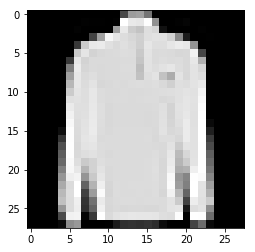

In [191]:
plt.imshow(train_data.train_data[np.random.choice(len(train_data))].numpy(), cmap='gray')
plt.show()

In [194]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

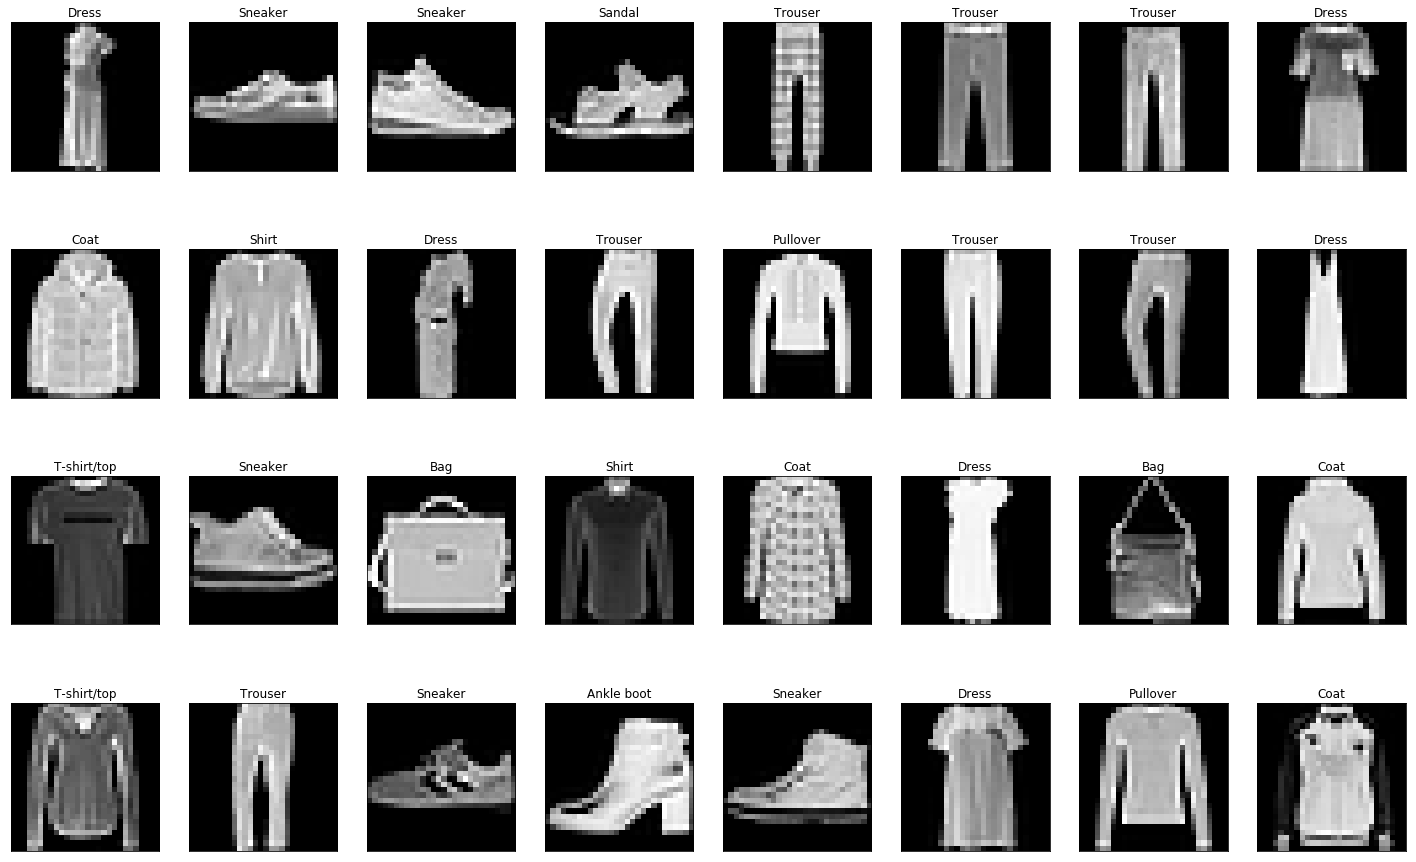

In [195]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() #change to np format

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [225]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # input size: 1 x 28 x 28
        # conv layer 1:
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F+2P)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)

        # maxpool layer 1
        # pool with kernel_size=2, stride=2
        # after one pool layer, this becomes (10, 13, 13)
        self.pool1 = nn.MaxPool2d(2, 2)        
        
        # conv layer 3:
        ## output size = (W-F+2P)/S +1 = (13-3+2*1)/1 +1 = 11
        # the output Tensor for one image, will have the dimensions: (32, 13, 13)
        self.conv2 = nn.Conv2d(10, 32, 3, padding=1)
        
        # maxpool layer 2
        # pool with kernel_size=2, stride=2
        # after one pool layer, this becomes (32, 6, 6) #rounded down
        self.pool2 = nn.MaxPool2d(2, 2)   
        
        self.dropout1 = nn.Dropout(p=0.3)
        
        # 32 outputs * the 6*6 filtered/pooled map size
        # 256 output channels 
        self.fc1 = nn.Linear(32*6*6, 128)

        # 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(128, 10)     
        
        self.dropout2 = nn.Dropout(p=0.5)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout1(x)

        # prep for linear layer
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)

        # one linear layer
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc2(x))
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        #x = F.log_softmax(x, dim=1)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout2): Dropout(p=0.5)
)


In [226]:
import torch.optim as optim

# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

## TODO: specify optimizer 
# stochastic gradient descent with a small learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [227]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  9.97


In [228]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [ ]:
# define the number of epochs to train for
n_epochs = 100 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.0116990299522877
Epoch: 2, Batch: 1000, Avg. Loss: 0.7010929889529943
Epoch: 3, Batch: 1000, Avg. Loss: 0.6483715934455395
Epoch: 4, Batch: 1000, Avg. Loss: 0.6254874361753464
Epoch: 5, Batch: 1000, Avg. Loss: 0.596771321028471
Epoch: 6, Batch: 1000, Avg. Loss: 0.5328656223267317
Epoch: 7, Batch: 1000, Avg. Loss: 0.34050782898068427
Epoch: 8, Batch: 1000, Avg. Loss: 0.3200887240990996
Epoch: 9, Batch: 1000, Avg. Loss: 0.32336387755721807
Epoch: 10, Batch: 1000, Avg. Loss: 0.3104006321579218


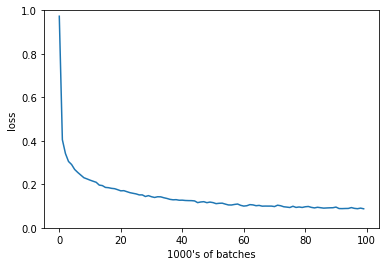

In [174]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.show()

In [180]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.385923

Test Accuracy of T-shirt/top: 85% (852/1000)
Test Accuracy of Trouser: 98% (985/1000)
Test Accuracy of Pullover: 89% (893/1000)
Test Accuracy of Dress: 93% (934/1000)
Test Accuracy of  Coat: 87% (873/1000)
Test Accuracy of Sandal: 97% (976/1000)
Test Accuracy of Shirt: 79% (792/1000)
Test Accuracy of Sneaker: 97% (978/1000)
Test Accuracy of   Bag: 97% (977/1000)
Test Accuracy of Ankle boot: 96% (961/1000)

Test Accuracy (Overall): 92% (9221/10000)


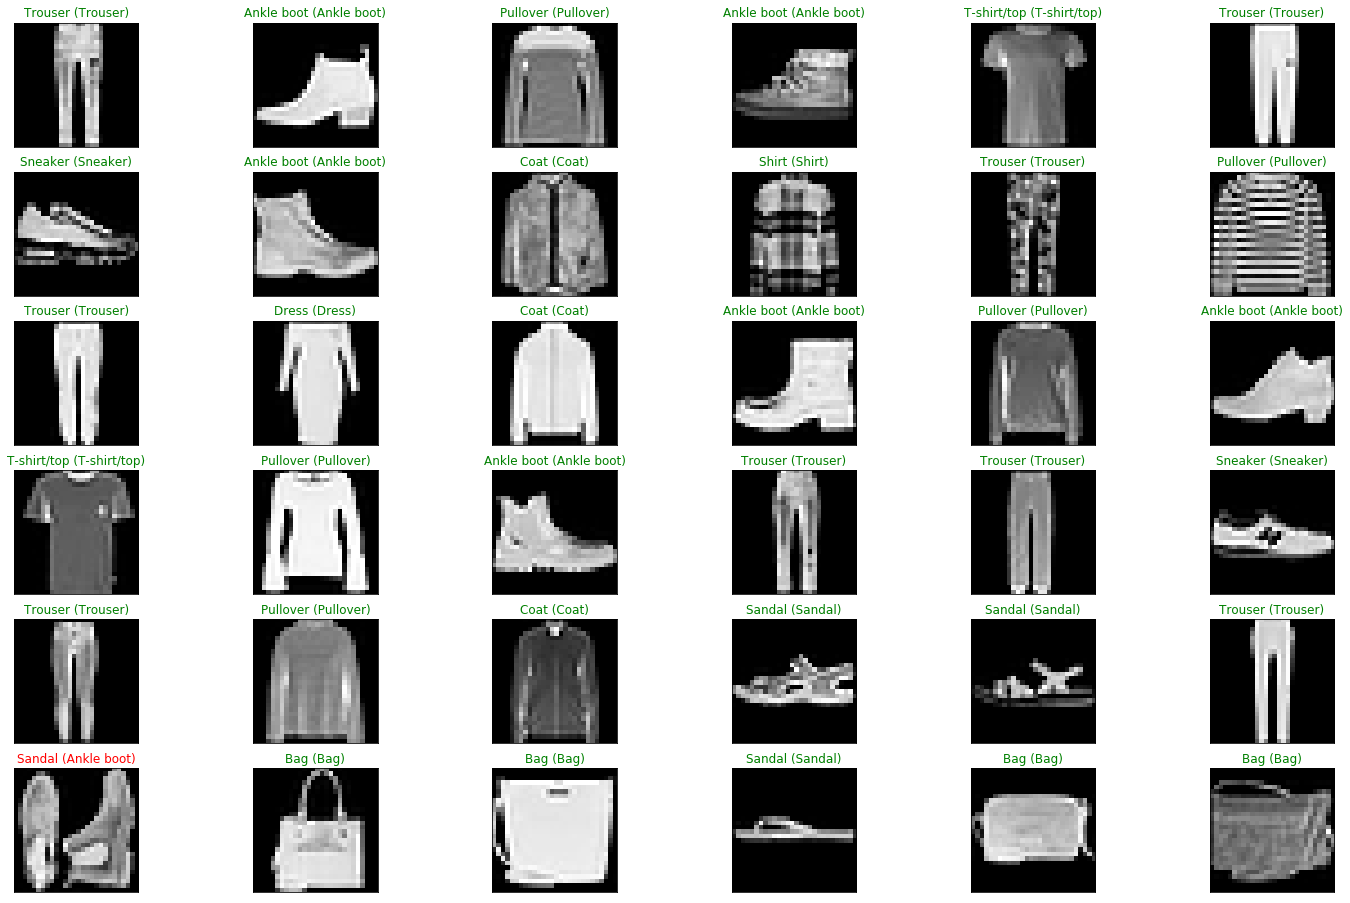

In [184]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(6, batch_size/6, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [185]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)

In [154]:
c = np.random.rand(10,1)
x = np.random.rand(10,1)
std = 0.05

def kernel_value(x, c, std=0.05):
    return np.mean(np.exp(-(np.square(x-c))/(2*std**2)))

kernel_value(x, c)

0.20626766707098687